In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image
import numpy as np

def get_training_data(image_path):
    """Loads an image from the given path into a numpy array."""
    with Image.open(image_path) as img:
        return np.array(img)

In [3]:
bad_dir = './Denoising/good'
good_dir = './Denoising/bad'

In [7]:
# [(480, 640, 3)]

In [23]:
x, y = [], []

sizes = []

for i in os.listdir(bad_dir + '/'):
    img = plt.imread(bad_dir + '/' + i)
    img = np.array(img)

    if img.shape not in sizes:
        sizes.append(img.shape)
    
    if img.shape[0] == 480 and img.shape[1] == 640 and img.shape[2] == 3:
        x.append(img)
        y.append(1)

for i in os.listdir(good_dir + '/'):
    img = plt.imread(good_dir + '/' + i)
    img = np.array(img)

    if img.shape not in sizes:
        sizes.append(img.shape)
    
    if img.shape[0] == 480 and img.shape[1] == 640 and img.shape[2] == 3:
        x.append(img)
        y.append(0)

x = np.asarray(x)
y = np.asarray(y)

In [24]:
print(sizes)

[(480, 640, 3)]


In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(397, 480, 640, 3) (397,)
(132, 480, 640, 3) (132,)
(133, 480, 640, 3) (133,)


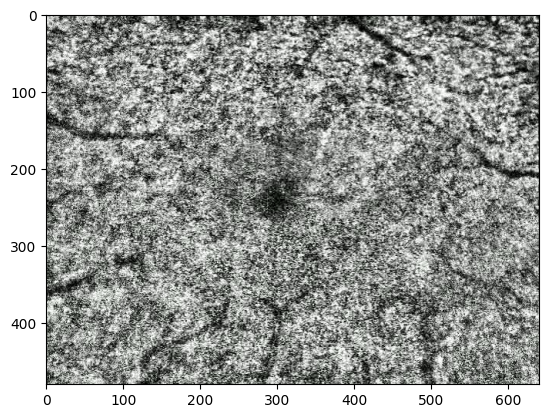

In [26]:
plt.imshow(img, cmap='gray')

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [31]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (480,640,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer='adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 480, 640, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 480, 640, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 240, 320, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 320, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 240, 320, 64)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 240, 320, 64)     

In [32]:
%%time
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

CPU times: user 21 µs, sys: 7 µs, total: 28 µs
Wall time: 36 µs


In [33]:
%%time
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 12, validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
13/13 [==============================] - 59s 4s/step - loss: 14.9297 - accuracy: 0.7809 - val_loss: 17.2648 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 2/12
13/13 [==============================] - 58s 4s/step - loss: 1.9275 - accuracy: 0.8791 - val_loss: 45.6056 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 3/12
13/13 [==============================] - ETA: 0s - loss: 1.9167 - accuracy: 0.8967
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
13/13 [==============================] - 58s 5s/step - loss: 1.9167 - accuracy: 0.8967 - val_loss: 48.0360 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 4/12
13/13 [==============================] - 60s 5s/step - loss: 1.7985 - accuracy: 0.9144 - val_loss: 42.7968 - val_accuracy: 0.6767 - lr: 3.0000e-04
Epoch 5/12
13/13 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.9018
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
13/13 [==============================] - 61s 5s/st

In [34]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

5/5 [==============================] - 4s 634ms/step - loss: 28.5625 - accuracy: 0.8030
Loss of the model is -  28.56252670288086
5/5 [==============================] - 4s 642ms/step - loss: 28.5625 - accuracy: 0.8030
Accuracy of the model is -  80.30303120613098 %


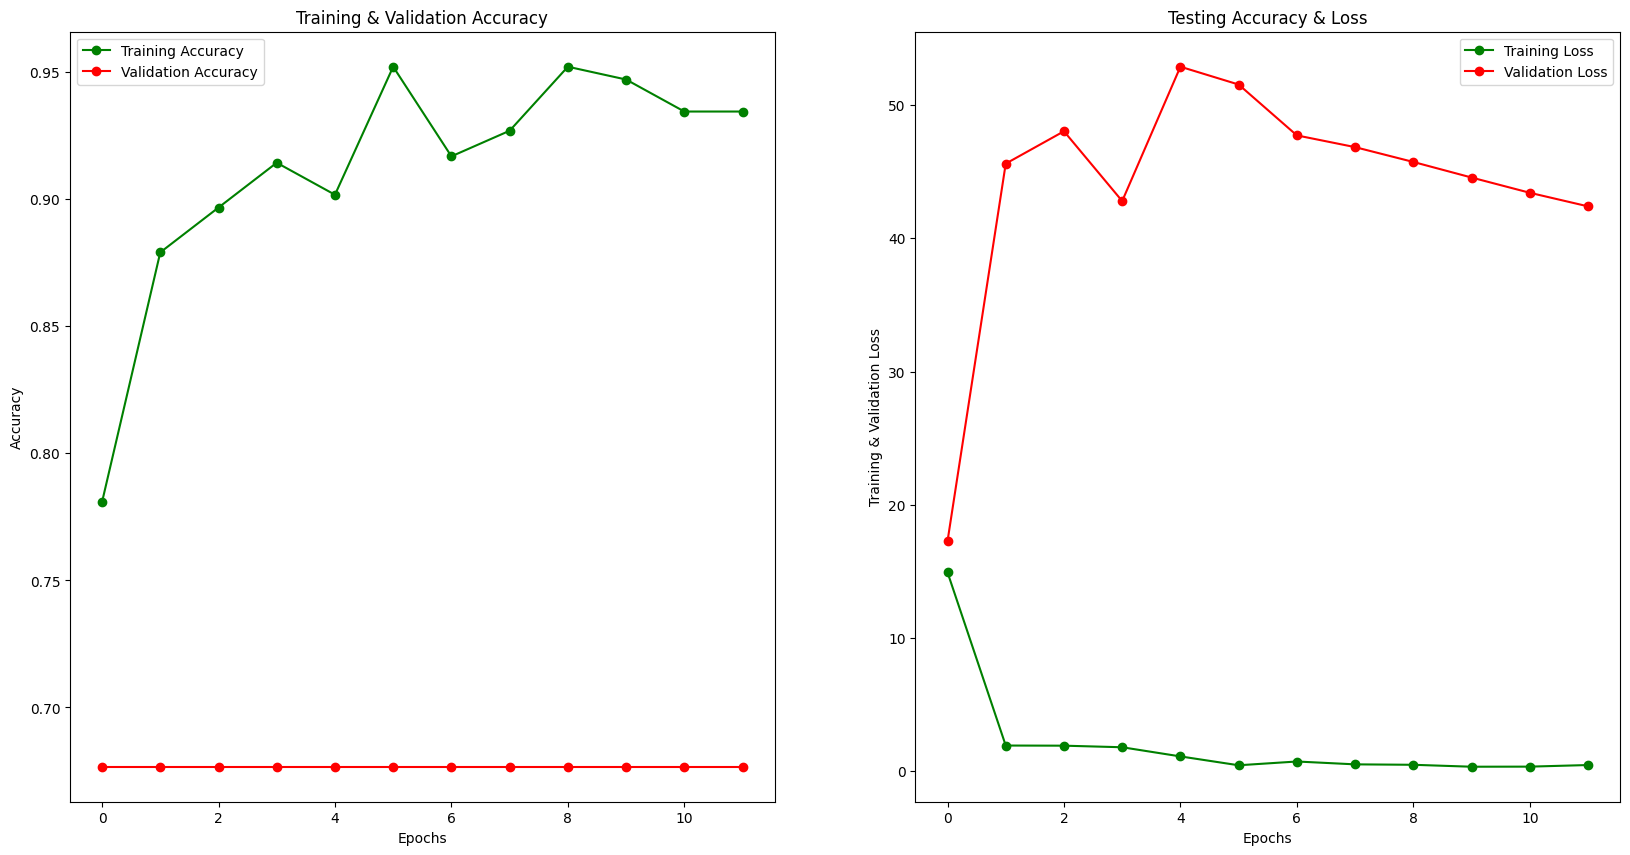

In [35]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [25]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

for i in range(len(predictions)):
    predictions[i] = (predictions[i] >= 0.5)

4/4 [==============================] - 4s 810ms/step


In [26]:
print(classification_report(y_test, predictions, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.00      0.00      0.00        20
Malignant (Class 1)       0.84      1.00      0.91       104

           accuracy                           0.84       124
          macro avg       0.42      0.50      0.46       124
       weighted avg       0.70      0.84      0.77       124



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cm = confusion_matrix(y_test,predictions)
cm

array([[  0,  20],
       [  0, 104]])

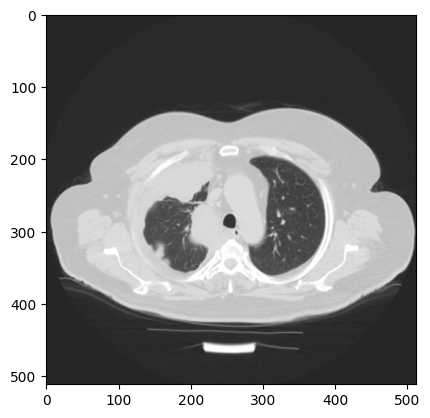

In [28]:
plt.imshow(x_test[0])

In [44]:
test_prediction = model.predict(np.array([x_test[1]]))

1/1 [==============================] - 0s 142ms/step


In [45]:
test_prediction

array([[1.]], dtype=float32)

In [53]:
model_json = model.to_json()

In [55]:
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

In [52]:
my_model = load_model('my_model.keras')

AttributeError: 'RMSprop' object has no attribute 'build'

In [48]:
test_prediction = test_model.predict(np.array([x_test[1]]))

1/1 [==============================] - 0s 58ms/step


In [49]:
test_prediction

array([[1.]], dtype=float32)

In [32]:
def getModelArchitecture():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (512,512,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()
    return model

test = getModelArchitecture()  # assuming you have a function to create your model architecture
test.load_weights('cnn_weights.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 512, 512, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 64)     

In [41]:
test_model = getModelArchitecture()  # assuming you have a function to create your model architecture
test_model.load_weights('./Cancer360/cnn_weights.h5')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 batch_normalization_25 (Ba  (None, 512, 512, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 256, 256, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 dropout_20 (Dropout)        (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_26 (Ba  (None, 256, 256, 64)     

In [42]:
test_prediction = test_model.predict(np.array([x_test[1]]))

1/1 [==============================] - 0s 93ms/step


In [43]:
test_prediction

array([[1.]], dtype=float32)

In [ ]:
custom_objects_dict = {
    'CustomLayer': CustomLayer,
    'custom_loss': custom_loss_function,
    # ... any other custom objects
}
model = load_model('image_cnn.keras', custom_objects=custom_objects_dict)
